In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [13]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast, approximate_kernel_expectation
import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [3]:
include("UniSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
function predict_UT(f, qx,qw, meta)
    qz = ReactiveMP.approximate(meta, f, (qx,))
    prediction_x = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ = qz, q_τ = qw)
    return prediction_x
end

#prediction
function predict_new(x_test,qv,qw,qθ,meta)
    prediction_y = @call_rule UniSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction_y
end

function predict_future_val(qx,qv,qw,qθ,meta)
    prediction_y = @call_rule UniSGP(:out, Marginalisation) (q_in=qx,q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction_y
end

function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = PointMass(observation), m_v = PointMass(var_y))
    x = ReactiveMP.prod(GenericProd(), prior_prediction, likelihood_update)
    return x
end

UpdateState (generic function with 1 method)

In [5]:
#Generate data 
Random.seed!(1471)
function generate_data(n,var_x,var_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + sqrt(var_x) * randn()
        observation[i] = latent_state[i] + sqrt(var_y) * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

N = 1000 #number of data 
n_train = 300
n_test = N - n_train
var_x = 0.1
var_y = 0.01
transition_func = (x) -> 0.8 + (x + 0.2) * (1 - 5 / (1 + exp(-2*x)))

#211 (generic function with 1 method)

In [6]:
true_state, data = generate_data(N,var_x,var_y);
true_state_train = true_state[1:n_train]
true_state_test = true_state[n_train+1 : end];
data_train = data[1:n_train];
data_test = data[n_train+1:end];

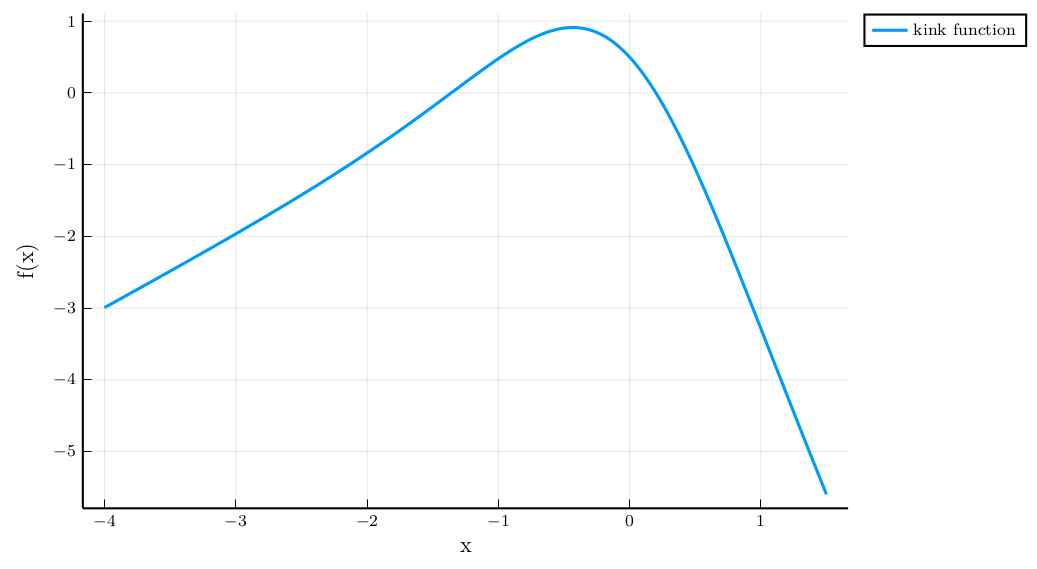

In [7]:
# #plot kink function 
X = collect(-4:0.01:1.5)
plot(X, transition_func.(X),lw=1.5, label="kink function")
xlabel!("x")
ylabel!("f(x)")

## Specify model

In [14]:
@model function kink_model(y,Xu,θ)
    v ~ MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    w ~ GammaShapeRate(0.01,0.01)
    x_prev ~ NormalMeanVariance(0, 50)

    for i=1:length(y)
        x[i] ~ UniSGP(x_prev,v,w,θ)
        y[i] ~ NormalMeanVariance(x[i],var_y)
        x_prev = x[i]
    end
end

## Run experiment

In [15]:
Nu = 20; #number of inducing points 
Xu = range(-4,1;length=Nu);
mean_gp = (x) -> 0
kernel_gp(θ) = θ[1] * with_lengthscale(Matern52Kernel(),θ[2])
;

In [16]:
@meta function meta_kink_model(Xu,kernel)
    UniSGP() -> UniSGPMeta(ghcubature(21),Xu,kernel)
end

gp_constraint = @constraints begin
    q(x_prev,x,v,w) = q(x)q(v)q(w)q(x_prev)
    q(x) = q(x[begin])..q(x[end])
end

gp_init = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    q(x) = NormalMeanVariance(0,50)
    q(w) = GammaShapeRate(0.01,0.01)
end
;

In [17]:
function my_free_energy(θ)
    
    infer_result = infer(
        model = kink_model(Xu = Xu, θ = θ,),
        iterations = 10,
        data = (y = data_train,),
        initialization = gp_init,
        constraints = gp_constraint,
        meta = meta_kink_model(Xu,kernel_gp),
        free_energy = true
    ) 
    
    return infer_result.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1]
    upper = [10,10]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [18]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,5)

2-element Vector{Float64}:
 2.19970703125
 2.6724121093749997

In [27]:
niter = 25;

infer_result = infer(
    model = kink_model(Xu = Xu, θ = θ_optimal,),
    iterations = niter,
    data = (y = data_train,),
    initialization = gp_init,
    constraints = gp_constraint,
    meta = meta_kink_model(Xu,kernel_gp),
    returnvars = (x = KeepLast(), v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

Inference results:
  Posteriors       | available for (w, v, x)
  Free Energy:     | Real[902.203, 454.518, 243.423, 223.27, 202.255, 198.722, 198.57, 198.695, 198.796, 198.857  …  198.93, 198.931, 198.931, 198.932, 198.932, 198.932, 198.932, 198.932, 198.932, 198.932]


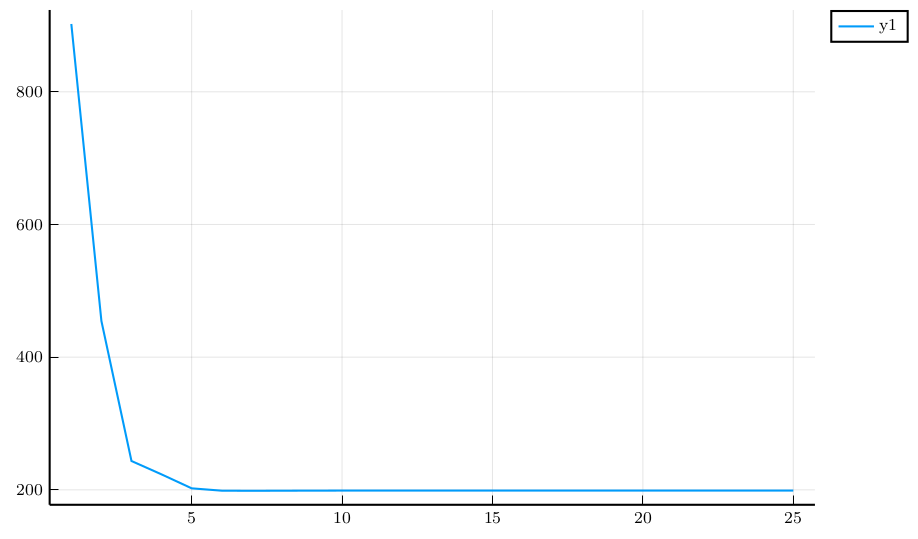

In [28]:
plot(infer_result.free_energy)

In [29]:
qv_gp = infer_result.posteriors[:v]
qx_gp = infer_result.posteriors[:x];
qw_gp = infer_result.posteriors[:w];

In [30]:
## plot inferred function
predict_mean =[]
predict_var =[]
for i=1:length(X)
    prediction = predict_new(X[i],qv_gp,qw_gp,PointMass(θ_optimal),UniSGPMeta(ghcubature(21),Xu,kernel_gp))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

## Inference with UT method (know function)

In [23]:
#unscented transform knows the exact transition function
@model function ssm_unscented(y)
    w ~ GammaShapeRate(0.01,0.01)
    x_prev ~ NormalMeanVariance(0, 50.)
    
    for i=1:length(y)
        temp_transition[i] ~ transition_func(x_prev)
        x[i] ~ NormalMeanPrecision(temp_transition[i],w)
        y[i] ~ NormalMeanVariance(x[i], var_y)
        x_prev = x[i]
    end
end

ut_constraint = @constraints begin
    q(x,w,temp_transition) = q(x)q(w)q(temp_transition)
end

ut_meta = @meta begin
    transition_func() -> UT()
end

ut_init = @initialization begin
    q(x) = NormalMeanVariance(0,50)
    q(w) = GammaShapeRate(0.01,0.01)
end

infer_result_UT = infer(
    model = ssm_unscented(),
    data = (y = data_train,),
    iterations = 25,
    initialization = ut_init,
    meta = ut_meta,
    constraints = ut_constraint,
    returnvars = (x = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
) 
qx_true = infer_result_UT.posteriors[:x];
qw_true = infer_result_UT.posteriors[:w];

## Comparison

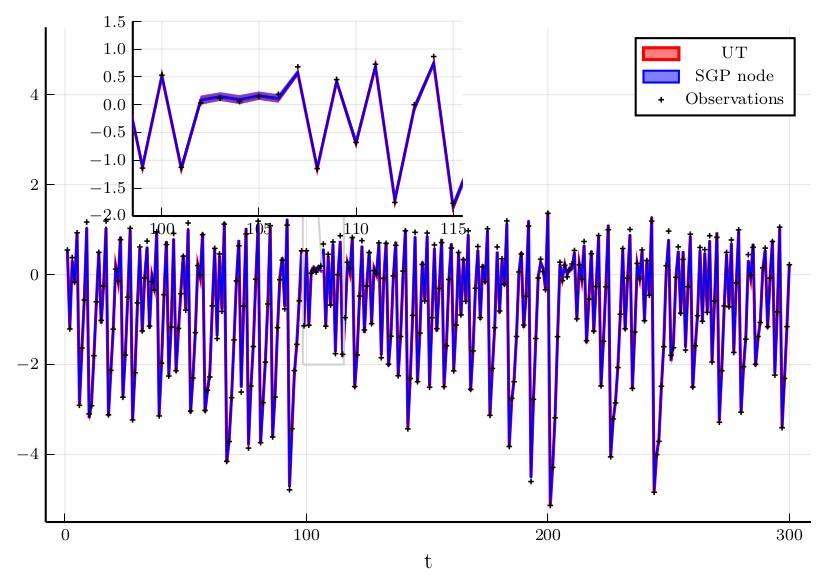

In [31]:
# compare inferred states
from_d = 1
to_d = length(mean.(qx_true))
skip_d = 1
plot(collect(1:300)[from_d:skip_d:to_d],mean.(qx_true)[from_d:skip_d:to_d], 
        ribbon = sqrt.(var.(qx_true))[from_d:skip_d:to_d],
        label="UT", lw=1.5,ylims=(-5.5,5.5),
        color=:red)

plot!(collect(1:300)[from_d:skip_d:to_d],
    mean.(qx_gp)[from_d:skip_d:to_d], 
    ribbon = sqrt.(var.(qx_gp)),label="SGP node",lw=1, legend=:topright,
    color=:blue)
xlabel!("t")
scatter!(collect(1:300)[from_d:skip_d:to_d],data_train[from_d:skip_d:to_d],marker=:cross,ms = 1.8,
        label="Observations")
lens!([98.5,115.5], [-2, 1.5], inset = (1, bbox(0.1, -0.01, 0.5, 0.5)))

In [52]:
savefig("texfiles/1dgpssm_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/1dgpssm_state.svg"

In [32]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
rmse_UT_state = rmse_score(true_state_train, mean.(qx_true))
rmse_GPnode = rmse_score(true_state_train, mean.(qx_gp))
println("The rmse of SGP node: $rmse_GPnode")
println("The rmse of UT: $rmse_UT_state")

The rmse of SGP node: 0.0832023495127354
The rmse of UT: 0.08334306668246552


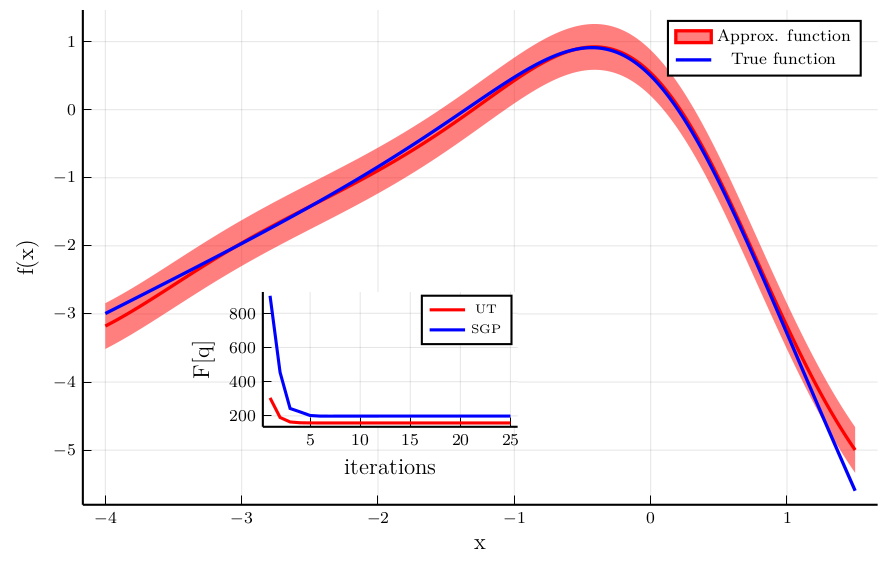

In [33]:
plot(X,predict_mean,ribbon = sqrt.(predict_var .+ 1e-7),
    label="Approx. function",lw=1.6, legend=:topright,
    color=:red)

plot!(X,transition_func.(X),label="True function",
    lw=1.6,
    color=:blue)
xlabel!("x")
ylabel!("f(x)")

# compare FE 
plot!([infer_result_UT.free_energy,infer_result.free_energy], 
    label=["UT" "SGP"],
    color=[:red :blue],
    lw= [1.5 1.5],
    legend=:topright,
    legend_font_pointsize=6,
    inset = (1, bbox(0.2, 0.13, 0.4, 0.4, :bottom, :left)),
    xlabel="iterations",
    ylabel="F[q]",
    subplot = 2)

In [55]:
savefig("texfiles/1dgpssm_approxfunction.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/1dgpssm_approxfunction.svg"

In [34]:
# compare prediction
## by GP
predict_future = []
var_predict_future = []
prev_state = qx_gp[end]
for i=1:100
    prediction = predict_future_val(prev_state,qv_gp,qw_gp,PointMass(θ_optimal), UniSGPMeta(ghcubature(21),Xu,kernel_gp))
    append!(predict_future,mean(prediction))
    append!(var_predict_future,var(prediction)) 
    prev_state = UpdateState(prediction,data_test[i])
end
## by UT
UT_predict_future = []
UT_var_predict_future = []
UT_prev_state = qx_true[end]
for i=1:100
    prediction = predict_UT(transition_func, UT_prev_state, qw_true, UT())
    append!(UT_predict_future,mean(prediction))
    append!(UT_var_predict_future,var(prediction)) 
    UT_prev_state = UpdateState(prediction,data_test[i])
end


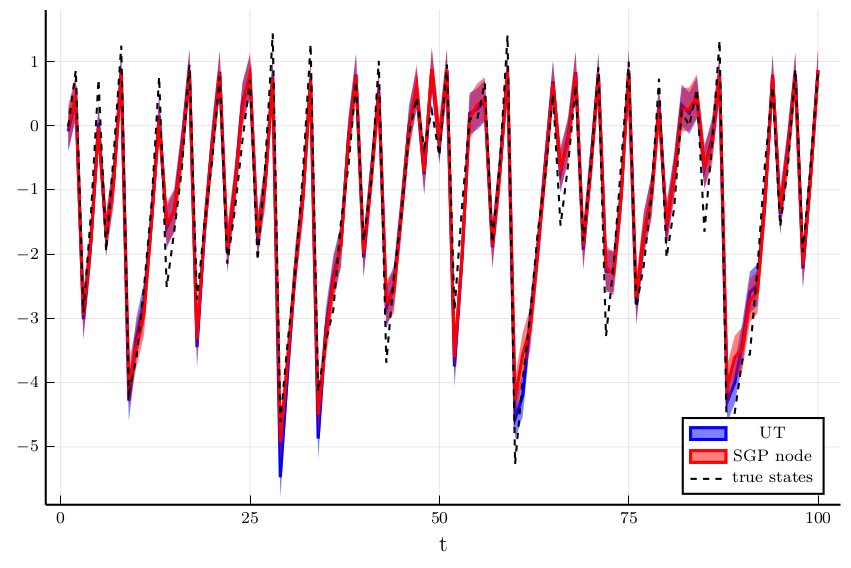

In [35]:
plot(UT_predict_future,ribbon=sqrt.(UT_var_predict_future),label="UT",lw=1.5, legend=:bottomright, color=:blue)
plot!(predict_future,ribbon=sqrt.(var_predict_future),label="SGP node", lw=1.5,ylims=(-5.9,1.8), color=:red)
plot!(true_state_test[1:100],label="true states", ls=:dash, color=:black)
xlabel!("t")
# title!("Predictive states")

In [58]:
savefig("texfiles/1dgpssm_1steppredict.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/1dgpssm_1steppredict.svg"

In [36]:
rmse_UT_prediction = rmse_score(true_state_test[1:100], UT_predict_future)
rmse_GPnode_prediction = rmse_score(true_state_test[1:100], predict_future)
println("The rmse of SGP node: $rmse_GPnode_prediction")
println("The rmse of UT: $rmse_UT_prediction")

The rmse of SGP node: 0.4365857091420439
The rmse of UT: 0.4307822844920243


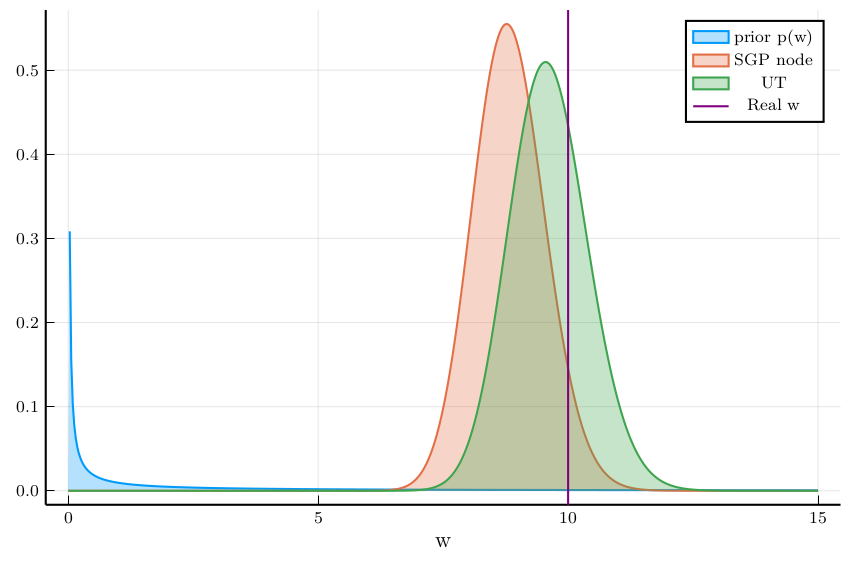

In [37]:
## inferred w 
# by sgp node 
rw = range(0,15,length = 500)


plot(rw, (x) -> pdf(GammaShapeRate(1e-2, 1e-2), x), fillalpha=0.3, fillrange = 0, label="prior p(w)", c=1,)
plot!(rw, (x) -> pdf(qw_gp, x), fillalpha=0.3, fillrange = 0, label="SGP node", c=2)
plot!(rw, (x) -> pdf(qw_true, x), fillalpha=0.3, fillrange = 0, label="UT", c=3, legend=:topright)
xlabel!("w")
vline!([1/var_x], label="Real w",color=:purple)

In [61]:
savefig("texfiles/1dgpssm_w.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/1dgpssm_w.svg"